<a href="https://colab.research.google.com/github/qmaruf/fastai/blob/master/fastai_dl2_pascal_mrf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing necessary modules

In [1]:
import sys
print (sys.version)

import sys
print (sys.version)
! pip3 install fastai==0.7.0
! pip3 install torchtext==0.2.3

3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
    100% |████████████████████████████████| 122kB 8.2MB/s 
    100% |████████████████████████████████| 3.6MB 10.3MB/s 
    100% |████████████████████████████████| 1.5MB 18.0MB/s 
    100% |████████████████████████████████| 496.4MB 37kB/s 
    100% |████████████████████████████████| 12.4MB 2.9MB/s 
    100% |████████████████████████████████| 61kB 23.2MB/s 
    100% |████████████████████████████████| 81kB 27.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/85/7d/12/2dfa5c0195f921ac935f5e8f27deada74972edc0ae9988a9c1
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built feather-format bcolz
mizani 0.5.3 has requirement pandas>=0.23.4, but you'll have pandas 0.22.0 which is incompatible.
plotnine 0.5.1 has requirement pandas>=0.23.4, but you'll have pandas 0.22.0 which is incompatible.
  Found existing installati

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.cuda.set_device(0)

In [4]:

# Download data
!mkdir data
!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar -P data/
!wget https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip -P data/
!tar -xf data/VOCtrainval_06-Nov-2007.tar -C data/
!unzip data/PASCAL_VOC.zip -d data/
!rm -rf data/PASCAL_VOC.zip data/VOCtrainval_06-Nov-2007.tar

--2019-03-15 04:11:52--  http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.3.39
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar [following]
--2019-03-15 04:11:52--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘data/VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  19.0MB/s    in 22s     

2019-03-15 04:12:15 (19.7 MB/s) - ‘data/VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]

--2019-03-15 04:12:16--  https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.1

In [5]:
PATH = Path('data/PASCAL_VOC/')
list(PATH.iterdir())

[PosixPath('data/PASCAL_VOC/pascal_train2007.json'),
 PosixPath('data/PASCAL_VOC/pascal_val2012.json'),
 PosixPath('data/PASCAL_VOC/pascal_test2007.json'),
 PosixPath('data/PASCAL_VOC/pascal_val2007.json'),
 PosixPath('data/PASCAL_VOC/pascal_train2012.json')]

In [6]:
train_json = json.load((PATH/'pascal_train2007.json').open())
print (train_json.keys())

dict_keys(['images', 'type', 'annotations', 'categories'])


In [0]:
IMAGES, TYPE, ANNOTATIONS, CATEGORIES = ['images', 'type', 'annotations', 'categories']

In [8]:
train_json[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334},
 {'file_name': '000026.jpg', 'height': 333, 'id': 26, 'width': 500},
 {'file_name': '000032.jpg', 'height': 281, 'id': 32, 'width': 500}]

In [9]:
train_json[ANNOTATIONS][:2]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
 {'area': 13110,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]}]

In [10]:
train_json[CATEGORIES][:10]

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
 {'id': 3, 'name': 'bird', 'supercategory': 'none'},
 {'id': 4, 'name': 'boat', 'supercategory': 'none'},
 {'id': 5, 'name': 'bottle', 'supercategory': 'none'},
 {'id': 6, 'name': 'bus', 'supercategory': 'none'},
 {'id': 7, 'name': 'car', 'supercategory': 'none'},
 {'id': 8, 'name': 'cat', 'supercategory': 'none'},
 {'id': 9, 'name': 'chair', 'supercategory': 'none'},
 {'id': 10, 'name': 'cow', 'supercategory': 'none'}]

In [0]:
id_to_name = {item['id']:item['name'] for item in train_json[CATEGORIES]}
id_to_filename = {item['id']:item['file_name'] for item in train_json[IMAGES]}
ids = [item['id'] for item in train_json[IMAGES]]

In [0]:
# images
#list((PATH/'VOCdevkit').iterdir())

In [0]:
train_jpegs = Path('./data/VOCdevkit/VOC2007/JPEGImages/')

In [0]:
#list(train_jpegs.iterdir())
#train_json[IMAGES]

In [0]:
def hw_bb(bb):
  return np.array([bb[1], bb[0], bb[1] + bb[3]- 1, bb[0] + bb[2] - 1])

In [0]:
train_anno = collections.defaultdict(lambda : [])
for n, item in enumerate(train_json[ANNOTATIONS]):
  if item['ignore'] == 0:
    bb = hw_bb(item['bbox'])
    id = item['image_id']
    train_anno[id].append((bb, item['category_id']))

In [17]:
len(train_anno)

2501

In [18]:
train_anno[ids[0]]

[(array([ 96, 155, 269, 350]), 7)]

In [0]:
def bb_hw(o):
  return np.array([o[1], o[0], o[3]-o[1], o[2]-o[0]])

In [0]:
img = open_image(train_jpegs/id_to_filename[ids[0]])

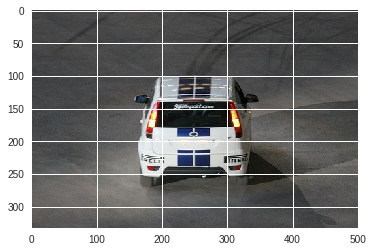

In [21]:
plt.imshow(img)

In [0]:
def show_img(img, figsize=None, ax=None):
  if ax is None: fig, ax = plt.subplots(figsize=figsize)
  ax.imshow(img)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  return ax

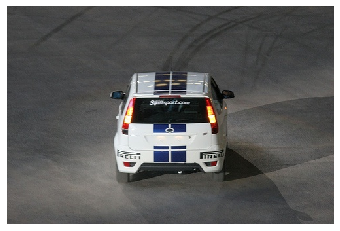

In [23]:
ax = show_img(img)

In [24]:
ax

In [0]:
# def draw_outline(o, linewidth):
#   o.set_path_effects([patheffects.Stroke(linewidth=linewidth, foreground='black'), patheffects.Normal()])

In [0]:
def draw_rect(ax, b):
  rect = patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', linewidth=2)
  ax.add_patch(rect)

In [0]:
def draw_text(ax, xy, txt):
  text = ax.text(*xy, txt, fontsize=14, color='white', weight='bold', backgroundcolor='black') 

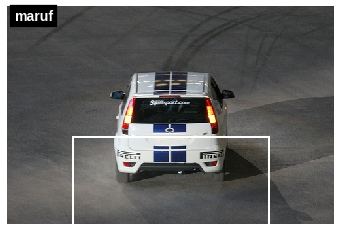

In [28]:
ax = show_img(img)
draw_rect(ax, [100,200,300,400])
draw_text(ax, (10, 20), 'maruf')

In [0]:
def draw_img(img, anno):
  ax = show_img(img, figsize=(16, 8))
  for bbox, cat_id in anno:
    bbox = bb_hw(bbox)
    draw_rect(ax, bbox)
    draw_text(ax, bbox[:2], id_to_name[cat_id])

In [0]:
def draw_idx(idx):
  img = open_image(train_jpegs/id_to_filename[idx])
  anno = train_anno[idx]
  draw_img(img, anno)

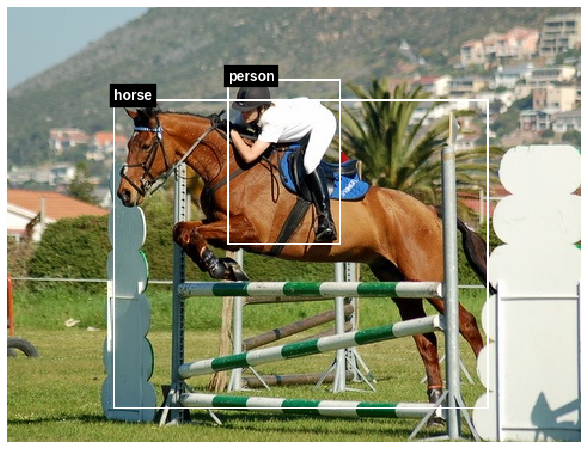

In [31]:
draw_idx(ids[1])

In [0]:
def get_large(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]
train_large_anno = {img_id: get_large(annos) for img_id, annos in train_anno.items() if len(annos)}

In [34]:
train_large_anno

{12: (array([ 96, 155, 269, 350]), 7),
 17: (array([ 77,  89, 335, 402]), 13),
 23: (array([  1,   2, 461, 242]), 15),
 26: (array([124,  89, 211, 336]), 7),
 32: (array([ 77, 103, 182, 374]), 1),
 33: (array([106,   8, 262, 498]), 1),
 34: (array([166, 115, 399, 359]), 19),
 35: (array([ 97, 217, 317, 464]), 15),
 36: (array([ 78,  26, 343, 318]), 12),
 42: (array([ 31, 262, 294, 499]), 19),
 44: (array([  0,   0, 329, 369]), 9),
 47: (array([  0,  14, 311, 458]), 7),
 48: (array([  0,   1, 499, 301]), 15),
 61: (array([ 10, 273, 278, 436]), 4),
 64: (array([ 22,   0, 499, 450]), 3),
 66: (array([181, 241, 258, 273]), 15),
 73: (array([142, 120, 459, 374]), 16),
 77: (array([  0,   1, 332, 305]), 8),
 78: (array([ 74,  14, 411, 474]), 12),
 83: (array([ 32, 108, 308, 446]), 7),
 89: (array([ 50,  21, 290, 316]), 9),
 91: (array([240, 124, 283, 194]), 7),
 104: (array([  6,   1, 332, 282]), 15),
 112: (array([173,  69, 327, 276]), 12),
 122: (array([ 19,  35, 473, 429]), 8),
 129: (arr

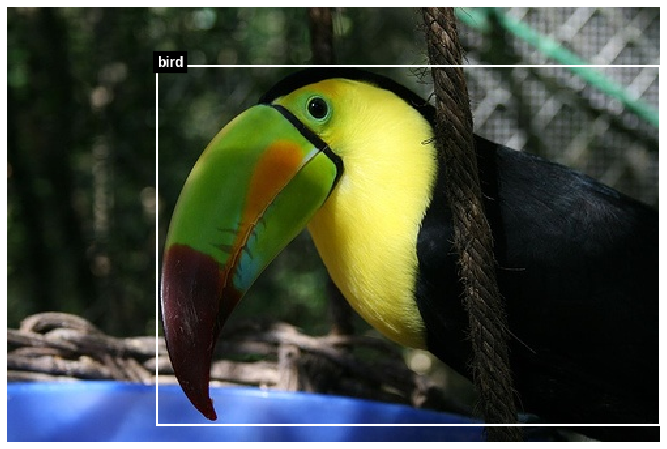

In [36]:
idx = ids[230]
b, c = train_large_anno[idx]
img = open_image(train_jpegs/id_to_filename[idx])
anno = train_large_anno[idx]
draw_img(img, [anno])
# anno, train_anno[idx]

In [37]:
for img_id, annos in train_anno.items():
  print (img_id, len(annos))

12 1
17 2
23 5
26 1
32 4
33 3
34 2
35 2
36 1
42 2
44 2
47 2
48 2
61 2
64 1
66 3
73 4
77 2
78 2
83 6
89 4
91 3
104 3
112 2
122 1
129 3
133 2
134 1
138 4
140 2
141 1
147 5
153 1
154 1
159 2
161 2
162 2
163 2
164 2
171 2
173 2
174 1
187 1
189 1
192 1
193 2
194 3
198 1
200 7
207 1
209 1
219 1
220 3
222 14
225 2
228 1
235 3
242 1
250 1
256 1
259 2
262 1
263 1
276 3
278 2
282 4
288 11
294 2
296 2
306 3
307 2
311 1
312 1
317 1
320 3
325 1
331 3
334 1
337 9
344 1
347 1
349 6
355 1
359 3
367 6
370 2
372 3
379 1
382 2
387 1
391 1
394 4
395 1
400 1
404 1
406 1
407 2
411 6
416 3
430 1
431 2
438 1
446 2
450 1
454 1
463 2
468 2
469 1
470 2
474 2
476 1
477 14
484 2
489 1
496 1
503 2
508 5
516 2
518 2
519 3
522 1
524 2
525 3
526 4
528 1
535 5
537 1
541 1
544 2
549 1
550 3
552 2
554 6
555 9
559 2
565 1
577 1
583 1
589 3
590 1
592 3
597 9
605 1
609 1
612 3
620 1
622 1
625 13
632 2
633 2
635 1
648 1
654 8
657 4
671 1
672 1
680 1
685 1
688 6
689 1
695 5
699 4
700 6
709 3
710 3
711 1
726 3
729 1
731 3
733 

In [0]:
train_anno[9755]

In [0]:
np.array(train_anno[9755])[0]